In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import shutil
import tracemalloc

# Visualizing Data

In [2]:
tracemalloc.start()

In [3]:
# get directory name(s)
data_directory = '../../data/white_blood_cell_images/'
data_subdirects = [f.path for f in os.scandir(data_directory) if f.is_dir()]
data_subdirects

['../../data/white_blood_cell_images/Basophil',
 '../../data/white_blood_cell_images/Neutrophil',
 '../../data/white_blood_cell_images/Monocyte',
 '../../data/white_blood_cell_images/Eosinophil',
 '../../data/white_blood_cell_images/Lymphocyte']

In [4]:
# obtaining the total number of images for each cell type
totals = {}
for directory in data_subdirects:
    label = directory.split('/')[-1]  # 'basophil', 'neutrophil', etc.
    totals[label] = len(os.listdir(directory))

In [5]:
totals

{'Basophil': 301,
 'Neutrophil': 10862,
 'Monocyte': 795,
 'Eosinophil': 1066,
 'Lymphocyte': 3609}

In [6]:
"Total number of images: " + str(sum(totals.values()))

'Total number of images: 16633'

Text(0.5, 1.0, 'Proportions of Immune Cell Types in Dataset (%)')

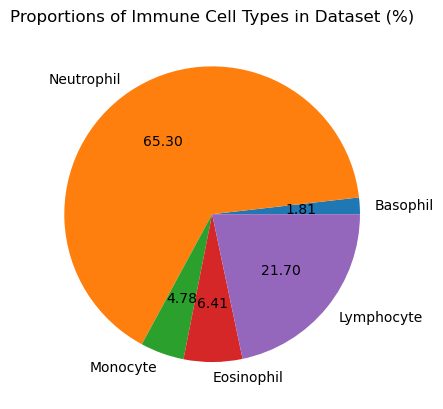

In [7]:
plt.pie(x=totals.values(), labels=totals.keys(), autopct='%.2f')
plt.title("Proportions of Immune Cell Types in Dataset (%)")

dataset is unbalanced

In [8]:
# for viewing images
import matplotlib.image as mpimg
import random

Cell Type: Basophil


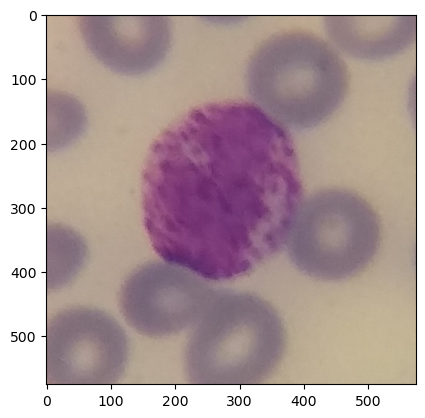

Cell Type: Neutrophil


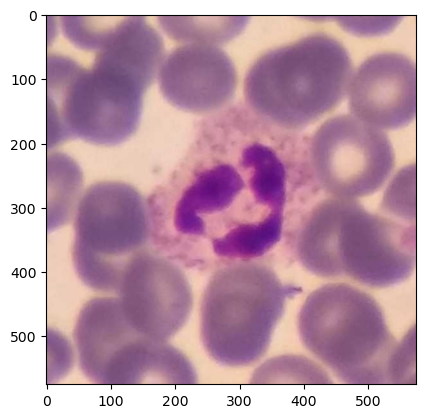

Cell Type: Monocyte


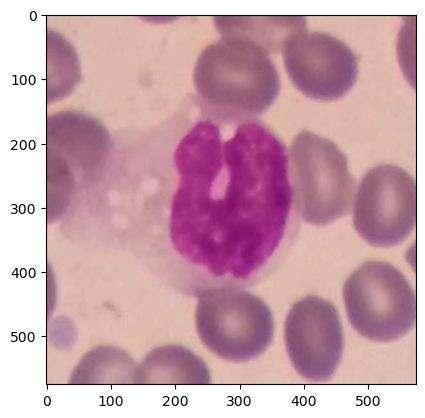

Cell Type: Eosinophil


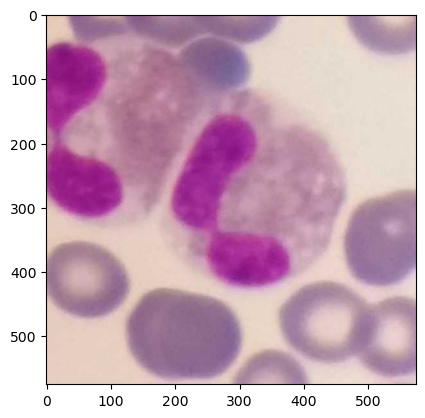

Cell Type: Lymphocyte


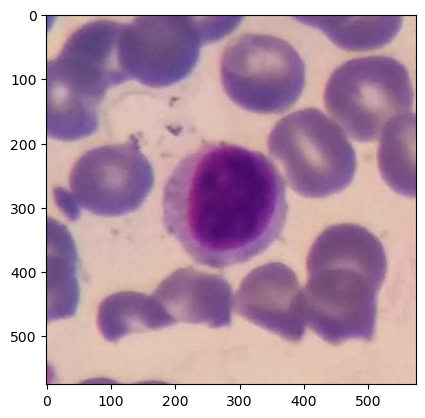

In [9]:
# viewing a random image from each of the 5 categories
for directory in data_subdirects:  
    all_category_paths = os.listdir(directory)  # list of paths to all images in category
    random_image_path = os.path.join(directory, random.choice(all_category_paths))
    label = directory.split('/')[-1]
    print(f"Cell Type: {label}")
    img = mpimg.imread(random_image_path)
    imgplot = plt.imshow(img)
    plt.show()

# Building Datasets and DataLoaders

In [10]:
from torch.utils.data import Dataset, DataLoader  # map-style dataset
import torchvision
from torchvision import transforms  # image transformations 
from torchvision.io import read_image  
from torchvision.transforms import v2  # apparently v2 is faster, also takes tensor as input instead of PIL
from PIL import Image
import os
import time
import random

In [11]:
# practicing converting image to tensor
img_path = "/Users/christian_g/python_projects/Data_Science_Projects/data/white_blood_cell_images/Eosinophil/95-5-4-1_73_1.jpg"
img = Image.open(img_path)

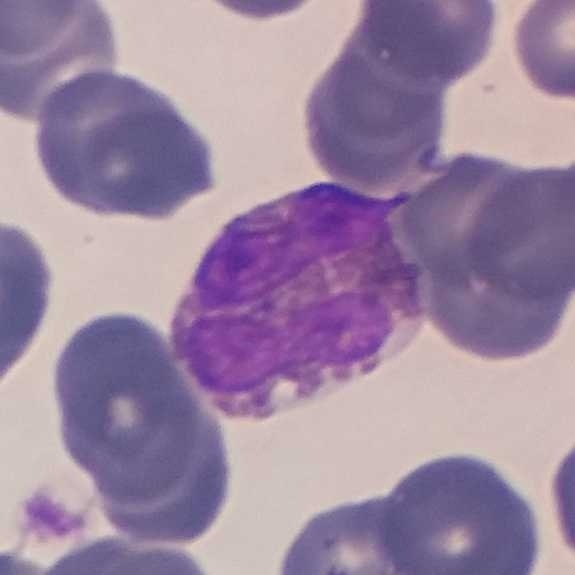

In [12]:
img

In [13]:
tensor_img=torchvision.io.read_image(path=img_path)
tensor_img.shape

torch.Size([3, 575, 575])

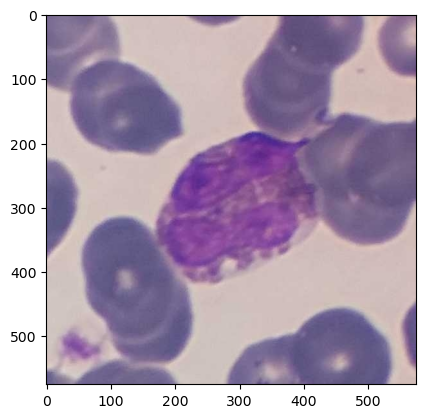

In [14]:
# making sure the image is the same after
plt.imshow(tensor_img.permute(1, 2, 0)) # use permute() to fix the order of dimensions

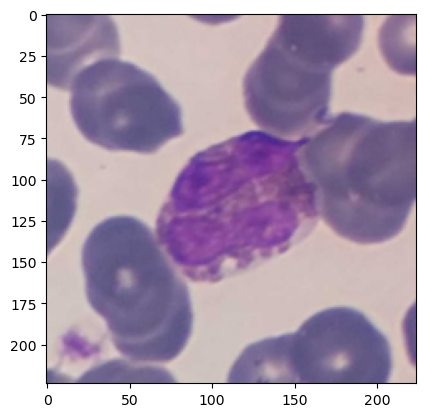

In [15]:
# practicing resizing image
resizer = transforms.Resize(size=(224, 224))
resized_img = resizer(tensor_img)
plt.imshow(resized_img.permute(1, 2, 0))

In [16]:
# transformations for training data
train_transform = v2.Compose([
    v2.Resize(size=(224, 224)),  # specs for imagenet
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.75, 1.0)), # scale --> lower and upper bounds of crop size
    v2.ToDtype(torch.float32, scale=True), # convert to float tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406],  # also specs for imagenet
    std=[0.229, 0.224, 0.225])
    ])

# sometimes RandomResizeCrop moves the cell out of frame, may cause a problem for some samples

# transformations for test (and validation ?) data
test_transform = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
    ])

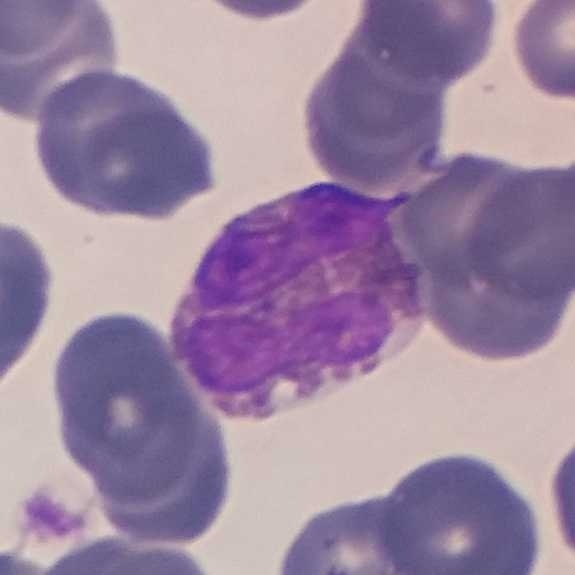

In [17]:
img

In [18]:
train_transform(tensor_img)

tensor([[[ 1.4783,  1.5468,  1.5982,  ...,  0.3309,  0.3138,  0.2796],
         [ 1.4269,  1.5125,  1.5810,  ...,  0.3309,  0.3138,  0.2796],
         [ 1.2899,  1.4098,  1.5297,  ...,  0.3309,  0.3138,  0.2624],
         ...,
         [-0.3883, -0.4739, -0.5253,  ..., -0.1999, -0.2171, -0.2342],
         [-0.3369, -0.4226, -0.4911,  ..., -0.2171, -0.2171, -0.2342],
         [-0.3027, -0.4054, -0.4911,  ..., -0.2342, -0.2342, -0.2342]],

        [[ 1.1155,  1.2031,  1.2556,  ...,  0.1702,  0.1527,  0.1001],
         [ 1.0455,  1.1331,  1.2031,  ...,  0.1702,  0.1527,  0.1176],
         [ 0.8880,  1.0280,  1.1506,  ...,  0.1702,  0.1527,  0.1001],
         ...,
         [-0.4426, -0.5126, -0.5476,  ..., -0.2675, -0.2850, -0.3025],
         [-0.3725, -0.4601, -0.5126,  ..., -0.2850, -0.2850, -0.3025],
         [-0.3375, -0.4251, -0.5126,  ..., -0.3025, -0.3025, -0.3025]],

        [[ 1.3328,  1.3851,  1.4025,  ...,  0.9842,  0.9842,  0.9842],
         [ 1.3851,  1.4200,  1.4374,  ...,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


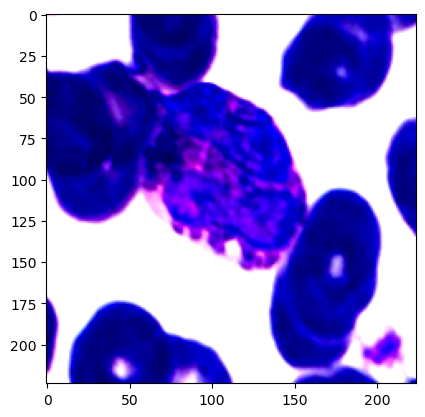

In [19]:
plt.imshow(train_transform(tensor_img).permute((1, 2, 0)))

In [20]:
# custom pytorch dataset

class ImmuneCellImageDataset(Dataset):
    def __init__(self, img_paths: list, class_map: dict, transform=None, device=torch.device('cpu')):
        self.img_paths=img_paths
        self.class_map=class_map
        self.transform=transform
        self.device = device
        self.unique_labels=list(class_map.values())
        
    def __getitem__(self, idx):
        # get image path with index
        img_path = self.img_paths[idx]

        # read image as tensor
        img_as_tensor = read_image(img_path)
        assert self.transform is not None, "Error: must specify image transformation"
        img_as_tensor = self.transform(img_as_tensor)  # apply specified transformation to image
        img_as_tensor = img_as_tensor.to(self.device)  # move to given device
        
        # get image label
        img_class = img_path.split('/')[-2]  # image class: str
        img_label = self.class_map[img_class]  # maps class to tensor label
        img_label = img_label.to(self.device)

        return img_as_tensor, img_label

    def __len__(self):
        return len(self.img_paths)

    def show_image(self, idx):
        """
        shows image at given idx  ** without transformations
        """
        
        # get image path with index
        img_path = self.img_paths[idx]

        # get image class
        img_class = img_path.split('/')[-2]
        
        # show image
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f'Cell Type: {img_class}, Idx: {idx}')

    def immune_cell_counts(self):
        cell_type_counts = {cell_type: 0 for cell_type, _ in self.class_map.items()}  # getting cell types from class map because I'm lazy

        for img_path in self.img_paths:
            img_cell_type = img_path.split('/')[-2]
            cell_type_counts[img_cell_type] += 1

        return cell_type_counts

In [21]:
# creating label tensors
class_names = ['Basophil', 'Neutrophil', 'Monocyte', 'Eosinophil', 'Lymphocyte']

class_map = {}
for i, class_name in enumerate(class_names):
    class_map[class_name] = torch.tensor(i)

# maps cell types to target tensors
class_map

{'Basophil': tensor(0),
 'Neutrophil': tensor(1),
 'Monocyte': tensor(2),
 'Eosinophil': tensor(3),
 'Lymphocyte': tensor(4)}

In [22]:
# invert class mapping, for future use?
class_map_inv = {v: k for k, v in class_map.items()}
class_map_inv

{tensor(0): 'Basophil',
 tensor(1): 'Neutrophil',
 tensor(2): 'Monocyte',
 tensor(3): 'Eosinophil',
 tensor(4): 'Lymphocyte'}

In [23]:
# setting device to gpu if available
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='mps')

In [24]:
# obtain all image paths
all_img_paths = []
for directory in data_subdirects:
    all_subdirect_paths = [os.path.join(directory, subdirect_path) for subdirect_path in os.listdir(directory)]
    all_img_paths.extend(all_subdirect_paths)

In [25]:
# splitting image paths 75 / 15 / 10 (train, validation, test)
data_split_percentages = {'train': 0.75, 'valid': 0.15, 'test': 0.1}

random.shuffle(all_img_paths)  # inplace shuffle
num_images = len(all_img_paths)

train_split_idx = int(num_images * data_split_percentages['train'])
valid_split_idx = int(num_images * (data_split_percentages['train'] + data_split_percentages['valid']))

train_img_paths = all_img_paths[:train_split_idx]
valid_img_paths = all_img_paths[train_split_idx:valid_split_idx]
test_img_paths = all_img_paths[valid_split_idx:]

assert train_img_paths + valid_img_paths + test_img_paths == all_img_paths, 'Error splitting image paths'

In [26]:
# create dataset objects
train_dataset = ImmuneCellImageDataset(img_paths=train_img_paths, class_map=class_map, transform=train_transform, device=device)
validation_dataset = ImmuneCellImageDataset(img_paths=valid_img_paths, class_map=class_map, transform=test_transform, device=device)
test_dataset = ImmuneCellImageDataset(img_paths=test_img_paths, class_map=class_map, transform=test_transform, device=device)

In [27]:
del all_img_paths

In [28]:
# verifying image transformations applied correctly 
[data.transform for data in [train_dataset, validation_dataset, test_dataset]]

[Compose(
       Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
       RandomHorizontalFlip(p=0.5)
       RandomResizedCrop(size=(224, 224), scale=(0.75, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
       ToDtype(scale=True)
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 ),
 Compose(
       Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
       ToDtype(scale=True)
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 ),
 Compose(
       Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
       ToDtype(scale=True)
       Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
 )]

In [29]:
# checking devices 
[dataset.device for dataset in [train_dataset, validation_dataset, test_dataset]]

[device(type='mps'), device(type='mps'), device(type='mps')]

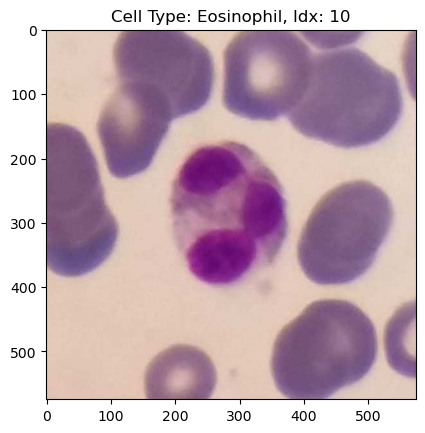

In [30]:
# viewing an image
train_dataset.show_image(10)

In [31]:
# checking immune cell counts for train, validation, and test data
[train_dataset.immune_cell_counts(), validation_dataset.immune_cell_counts(), test_dataset.immune_cell_counts()]

[{'Basophil': 216,
  'Neutrophil': 8128,
  'Monocyte': 603,
  'Eosinophil': 799,
  'Lymphocyte': 2728},
 {'Basophil': 58,
  'Neutrophil': 1643,
  'Monocyte': 110,
  'Eosinophil': 156,
  'Lymphocyte': 528},
 {'Basophil': 27,
  'Neutrophil': 1091,
  'Monocyte': 82,
  'Eosinophil': 111,
  'Lymphocyte': 353}]

In [32]:
# creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=25, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=25, shuffle=True)
# for some reason increasing num_workers breaks this. Seems to be a problem with using jupyter for multiprocessing, might be 
# fixed by moving to script

In [373]:
# number of batches in train, validation, and test datasets
[len(train_dataloader), len(validation_dataloader), len(test_dataloader)]

[499, 100, 67]

# Initializing Model (ResNet18)

In [48]:
import torchvision.models as models
import torch.nn as nn
import torchviz

In [375]:
# import resnet18 with default pretrained weights
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [49]:
# custom final layer for resnet18
class FinalBlock(nn.Module):
    def __init__(self):
        super(FinalBlock, self).__init__()
        
        self.fc = nn.Linear(512, 5)

    def forward(self, x):
        x = self.fc(x)
        return x

In [377]:
# replacing resnet18 fc with custom final block
final_block = FinalBlock()
resnet18.fc = final_block

In [378]:
# move to specified device
resnet18 = resnet18.to(device)

In [379]:
resnet18.forward

<bound method ResNet.forward of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [380]:
# freezing all model parameters (will unfreeze last layers later)
for parameter in resnet18.parameters():
    parameter.requires_grad = False
    assert parameter.requires_grad == False

In [381]:
# making sure the whole model is frozen
assert all([parameter.requires_grad == False for parameter in resnet18.parameters()])

# Defining Training, Validation, and Testing

In [382]:
import copy
import pdb
import numpy as np
import math
from utils.misc_utils import date_n_time

In [383]:
# hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
lr = 0.000001
optimizer = torch.optim.Adam(params=resnet18.parameters(), lr=lr)
num_epochs = 50

In [384]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    # set model to train mode
    model.train()
    
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for batch_idx, batch in enumerate(iter(dataloader)):
        # Every data instance is an input + label pair
        batch_inputs, batch_labels = batch

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        batch_outputs = model(batch_inputs)

        # Compute the loss and its gradients
        loss = loss_fn(batch_outputs, batch_labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        num_batches_per_update = 50  # number of batches for each print statement
        
        if batch_idx % num_batches_per_update == 0 and not batch_idx == 0:
            last_loss = running_loss / num_batches_per_update # loss per batch
            print(f'Batch {batch_idx} loss: {last_loss}')
            running_loss = 0.

    return last_loss

In [385]:
def validate_classification_model(dataloader, model, loss_fn, device):
    # set model to evaluation mode
    model.eval()
    
    batch_loss = 0
    batch_loss_list = []

    unique_labels = dataloader.dataset.unique_labels
    losses_for_unique_labels_raw = {unique_label: [] for unique_label in unique_labels}
    
    for batch in tqdm(iter(dataloader)):
        # Every data instance is an input + label pair
        batch_inputs, batch_labels = batch

        # Make predictions for this batch
        batch_outputs = model(batch_inputs).detach()
        
        # Compute the loss
        loss = loss_fn(batch_outputs, batch_labels)

        # get loss for each label
        for unique_label in unique_labels:
            if any(batch_labels == unique_label):
                batch_idxs_for_unique_label = batch_labels == unique_label
                
                batch_outputs_for_unique_label = batch_outputs[batch_idxs_for_unique_label]
                num_samples_in_batch = len(batch_outputs_for_unique_label)
                batch_targets_for_unique_label = unique_label.repeat(1, num_samples_in_batch).flatten().to(device)
               
                loss_for_unique_label = loss_fn(batch_outputs_for_unique_label, batch_targets_for_unique_label)
                loss_for_unique_label = loss_for_unique_label.item()
            else:
                loss_for_unique_label = 0
                num_samples_in_batch = 0
                
            losses_for_unique_labels_raw[unique_label].append((loss_for_unique_label, num_samples_in_batch))
        
        # Extract batch loss as float
        batch_loss = loss.item()

        # add batch loss to running list
        batch_loss_list.append(batch_loss) 

    losses_for_unique_labels = {unique_label: [] for unique_label in unique_labels}

    # obtain losses for each class by aggregating individual batch losses
    for unique_label in unique_labels:
        loss_list_for_unique_label_raw = losses_for_unique_labels_raw[unique_label]
        total_samples = sum([pair[1] for pair in loss_list_for_unique_label_raw])
        loss_weights = [pair[1]/total_samples for pair in loss_list_for_unique_label_raw]
        assert sum(loss_weights) == 1 
        weighted_losses = [pair[0] * loss_weights[i] for i, pair in enumerate(loss_list_for_unique_label_raw)]
        aggregated_class_loss = sum(weighted_losses)
        losses_for_unique_labels[unique_label] = aggregated_class_loss

    mean_validation_loss = np.mean(batch_loss_list)
    return mean_validation_loss, losses_for_unique_labels

In [386]:
# unfreezing all parameters until I stop being an idiot and figure out how to only unfreeze last layer
for parameter in resnet18.parameters():
    parameter.requires_grad = True
    assert parameter.requires_grad == True

In [387]:
# making sure last layer requires grad
for thing in resnet18.fc.fc.parameters():
    print(thing.requires_grad)

True
True


In [388]:
all_train_loss = []
all_validation_loss = []
all_class_validation_losses = {label: [] for label in list(class_map.values())}
all_model_paths = []
all_model_filenames = []

for epoch in range(1, num_epochs+1):
    print("-"*60)
    print("Epoch ", epoch)

    # train
    print("Starting Model Training...")
    last_train_loss = train_one_epoch(train_dataloader, resnet18, loss_fn, optimizer, device)
    print("Last train loss: ", last_train_loss)

    all_train_loss.append(last_train_loss)

    # validation
    print("Starting Model Validation...")
    mean_validation_loss, losses_for_unique_labels = validate_classification_model(validation_dataloader, resnet18, loss_fn, device)
    print("Mean validation loss: ", mean_validation_loss)
    print(f"Losses for individual classes: {losses_for_unique_labels}")

    all_validation_loss.append(mean_validation_loss)

    # record individual class labels
    for label in losses_for_unique_labels:
        all_class_validation_losses[label].append(losses_for_unique_labels[label]) # this is stupid, I know

    # saving model
    print("Saving model...")
    model_save_directory = 'models/'
    model_name = f'resnet18_epoch_{epoch}_time_{date_n_time()}'
    model_path = os.path.join(model_save_directory, model_name)
    torch.save(resnet18, model_path)

    all_model_filenames.append(model_path)
    assert os.path.exists(model_path), 'Model failed to save'
    print("Model saved")

------------------------------------------------------------
Epoch  1
Starting Model Training...
Batch 50 loss: 1.6230348992347716
Batch 100 loss: 1.5382174491882323
Batch 150 loss: 1.4763629007339478
Batch 200 loss: 1.4133348774909973
Batch 250 loss: 1.3569060206413268
Batch 300 loss: 1.2863251543045044
Batch 350 loss: 1.2109421730041503
Batch 400 loss: 1.197159059047699
Batch 450 loss: 1.115714271068573
Last train loss:  1.115714271068573
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.62it/s]


Mean validation loss:  0.9764199620485305
Losses for individual classes: {tensor(0): 2.215480273678189, tensor(1): 0.8986507358368981, tensor(2): 1.9235960275439894, tensor(3): 0.9900497260436513, tensor(4): 0.9045497488804616}
Saving model...
Model saved
------------------------------------------------------------
Epoch  2
Starting Model Training...
Batch 50 loss: 1.0194113385677337
Batch 100 loss: 0.9182295429706574
Batch 150 loss: 0.9129950094223023
Batch 200 loss: 0.8354871511459351
Batch 250 loss: 0.7806981432437897
Batch 300 loss: 0.7405023276805878
Batch 350 loss: 0.706960016489029
Batch 400 loss: 0.6878486478328705
Batch 450 loss: 0.6501182925701141
Last train loss:  0.6501182925701141
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.69it/s]


Mean validation loss:  0.5386006504297256
Losses for individual classes: {tensor(0): 1.6821992425691512, tensor(1): 0.4434092353313721, tensor(2): 1.6863053653199793, tensor(3): 0.9607241504332599, tensor(4): 0.3710370773990308}
Saving model...
Model saved
------------------------------------------------------------
Epoch  3
Starting Model Training...
Batch 50 loss: 0.5780182075500488
Batch 100 loss: 0.5557711935043335
Batch 150 loss: 0.5311104542016983
Batch 200 loss: 0.48550386548042296
Batch 250 loss: 0.5013881933689117
Batch 300 loss: 0.4315871775150299
Batch 350 loss: 0.4235967469215393
Batch 400 loss: 0.40342307209968564
Batch 450 loss: 0.40800432562828065
Last train loss:  0.40800432562828065
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.46it/s]


Mean validation loss:  0.3216306219995022
Losses for individual classes: {tensor(0): 1.1042138040065765, tensor(1): 0.18570010589316413, tensor(2): 1.3558446719484814, tensor(3): 0.9700707556570277, tensor(4): 0.26311715306400396}
Saving model...
Model saved
------------------------------------------------------------
Epoch  4
Starting Model Training...
Batch 50 loss: 0.37446588546037674
Batch 100 loss: 0.372242203950882
Batch 150 loss: 0.39174063116312025
Batch 200 loss: 0.36994179934263227
Batch 250 loss: 0.36848535865545273
Batch 300 loss: 0.29882349908351896
Batch 350 loss: 0.30395461827516557
Batch 400 loss: 0.32501851469278337
Batch 450 loss: 0.3019852313399315
Last train loss:  0.3019852313399315
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.23it/s]


Mean validation loss:  0.2424702174961567
Losses for individual classes: {tensor(0): 0.710361659526825, tensor(1): 0.10751576779245083, tensor(2): 1.090895606047016, tensor(3): 0.9287712396749485, tensor(4): 0.23353492102742623}
Saving model...
Model saved
------------------------------------------------------------
Epoch  5
Starting Model Training...
Batch 50 loss: 0.3131429946422577
Batch 100 loss: 0.29528423041105273
Batch 150 loss: 0.2955843713879585
Batch 200 loss: 0.2729866388440132
Batch 250 loss: 0.2745854686200619
Batch 300 loss: 0.2599023213982582
Batch 350 loss: 0.2627020215988159
Batch 400 loss: 0.25365702047944066
Batch 450 loss: 0.26391658052802086
Last train loss:  0.26391658052802086
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


Mean validation loss:  0.20006196536123752
Losses for individual classes: {tensor(0): 0.4237591077884038, tensor(1): 0.09245882865977405, tensor(2): 0.9296413636056043, tensor(3): 0.8061488895537028, tensor(4): 0.17656427270676073}
Saving model...
Model saved
------------------------------------------------------------
Epoch  6
Starting Model Training...
Batch 50 loss: 0.2486504140496254
Batch 100 loss: 0.24407020822167397
Batch 150 loss: 0.21754861369729042
Batch 200 loss: 0.2176711942255497
Batch 250 loss: 0.24130932688713075
Batch 300 loss: 0.22850989654660225
Batch 350 loss: 0.21830586686730385
Batch 400 loss: 0.21791924372315408
Batch 450 loss: 0.2397001539170742
Last train loss:  0.2397001539170742
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.60it/s]


Mean validation loss:  0.16962400294840335
Losses for individual classes: {tensor(0): 0.3273440420272804, tensor(1): 0.06741168241365239, tensor(2): 0.8237855157862275, tensor(3): 0.7436116765819344, tensor(4): 0.1596549134359338}
Saving model...
Model saved
------------------------------------------------------------
Epoch  7
Starting Model Training...
Batch 50 loss: 0.20273630440235138
Batch 100 loss: 0.2003498613834381
Batch 150 loss: 0.21560407102108
Batch 200 loss: 0.19614384040236474
Batch 250 loss: 0.2122565761208534
Batch 300 loss: 0.19763385966420174
Batch 350 loss: 0.17826911062002182
Batch 400 loss: 0.18902026757597923
Batch 450 loss: 0.18057269230484962
Last train loss:  0.18057269230484962
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.53it/s]


Mean validation loss:  0.14675270315259695
Losses for individual classes: {tensor(0): 0.23668114965160686, tensor(1): 0.06585187564278251, tensor(2): 0.7285128654438561, tensor(3): 0.6087105510378975, tensor(4): 0.1259435921553589}
Saving model...
Model saved
------------------------------------------------------------
Epoch  8
Starting Model Training...
Batch 50 loss: 0.1810362870246172
Batch 100 loss: 0.19577788092195988
Batch 150 loss: 0.1742118276655674
Batch 200 loss: 0.19243487268686293
Batch 250 loss: 0.17546894378960132
Batch 300 loss: 0.19426362559199334
Batch 350 loss: 0.18367691963911056
Batch 400 loss: 0.1718236193805933
Batch 450 loss: 0.1700810307264328
Last train loss:  0.1700810307264328
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.58it/s]


Mean validation loss:  0.13167373450472952
Losses for individual classes: {tensor(0): 0.18227115415391468, tensor(1): 0.052781492010621454, tensor(2): 0.6994942258727752, tensor(3): 0.615403606720707, tensor(4): 0.10417724092821441}
Saving model...
Model saved
------------------------------------------------------------
Epoch  9
Starting Model Training...
Batch 50 loss: 0.16784768216311932
Batch 100 loss: 0.14900159023702145
Batch 150 loss: 0.16991154387593269
Batch 200 loss: 0.1626665788143873
Batch 250 loss: 0.15333688087761402
Batch 300 loss: 0.164432730153203
Batch 350 loss: 0.15338855847716332
Batch 400 loss: 0.16808303408324718
Batch 450 loss: 0.16140033163130282
Last train loss:  0.16140033163130282
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.57it/s]


Mean validation loss:  0.118179632704705
Losses for individual classes: {tensor(0): 0.13942911333981015, tensor(1): 0.04953257087847502, tensor(2): 0.5857175339044909, tensor(3): 0.5609955388285658, tensor(4): 0.0967105144724971}
Saving model...
Model saved
------------------------------------------------------------
Epoch  10
Starting Model Training...
Batch 50 loss: 0.14500896975398064
Batch 100 loss: 0.1452265463769436
Batch 150 loss: 0.1469369962066412
Batch 200 loss: 0.14680552456527948
Batch 250 loss: 0.14408681727945805
Batch 300 loss: 0.13254758045077325
Batch 350 loss: 0.1379304861649871
Batch 400 loss: 0.12403110213577748
Batch 450 loss: 0.13572854809463025
Last train loss:  0.13572854809463025
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.43it/s]


Mean validation loss:  0.10804185749962926
Losses for individual classes: {tensor(0): 0.10923145287891937, tensor(1): 0.03856822537267443, tensor(2): 0.5391229808298965, tensor(3): 0.5174382541730416, tensor(4): 0.10746862440066259}
Saving model...
Model saved
------------------------------------------------------------
Epoch  11
Starting Model Training...
Batch 50 loss: 0.1246376246958971
Batch 100 loss: 0.11729337975382804
Batch 150 loss: 0.1518558106571436
Batch 200 loss: 0.13641493134200572
Batch 250 loss: 0.13625577419996263
Batch 300 loss: 0.12819452222436667
Batch 350 loss: 0.11959621679037809
Batch 400 loss: 0.1337832898274064
Batch 450 loss: 0.14812167353928088
Last train loss:  0.14812167353928088
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


Mean validation loss:  0.10101089202798903
Losses for individual classes: {tensor(0): 0.10540578982216262, tensor(1): 0.03570982399270434, tensor(2): 0.5129536056133398, tensor(3): 0.5011912219962896, tensor(4): 0.09465882560825743}
Saving model...
Model saved
------------------------------------------------------------
Epoch  12
Starting Model Training...
Batch 50 loss: 0.14227782499045133
Batch 100 loss: 0.1313848801329732
Batch 150 loss: 0.11655927684158086
Batch 200 loss: 0.11361283849924803
Batch 250 loss: 0.10259909745305777
Batch 300 loss: 0.1237612160295248
Batch 350 loss: 0.10959572866559028
Batch 400 loss: 0.12182610042393208
Batch 450 loss: 0.10652101028710603
Last train loss:  0.10652101028710603
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


Mean validation loss:  0.0957736732903868
Losses for individual classes: {tensor(0): 0.11811175467889932, tensor(1): 0.043120988482939715, tensor(2): 0.6324692496840479, tensor(3): 0.3945481196042832, tensor(4): 0.05259525773030335}
Saving model...
Model saved
------------------------------------------------------------
Epoch  13
Starting Model Training...
Batch 50 loss: 0.10285423219203949
Batch 100 loss: 0.13001504264771938
Batch 150 loss: 0.0991595708951354
Batch 200 loss: 0.10584015246480703
Batch 250 loss: 0.10543070036917924
Batch 300 loss: 0.10698748771101237
Batch 350 loss: 0.11464289970695972
Batch 400 loss: 0.10825528215616942
Batch 450 loss: 0.1308066600561142
Last train loss:  0.1308066600561142
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.61it/s]


Mean validation loss:  0.08789899641647934
Losses for individual classes: {tensor(0): 0.08572123677558487, tensor(1): 0.046840124172869646, tensor(2): 0.5022826148591684, tensor(3): 0.31656431491955433, tensor(4): 0.05773805228552671}
Saving model...
Model saved
------------------------------------------------------------
Epoch  14
Starting Model Training...
Batch 50 loss: 0.10306482918560506
Batch 100 loss: 0.11691604658961297
Batch 150 loss: 0.10625043611973524
Batch 200 loss: 0.12209524270147085
Batch 250 loss: 0.0958397302031517
Batch 300 loss: 0.08950454156845808
Batch 350 loss: 0.08966580554842948
Batch 400 loss: 0.1067881229147315
Batch 450 loss: 0.11674272786825896
Last train loss:  0.11674272786825896
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.66it/s]


Mean validation loss:  0.08320563049986958
Losses for individual classes: {tensor(0): 0.08839727220835075, tensor(1): 0.03359353655302356, tensor(2): 0.5161199550207515, tensor(3): 0.3770742174618409, tensor(4): 0.05548279978440053}
Saving model...
Model saved
------------------------------------------------------------
Epoch  15
Starting Model Training...
Batch 50 loss: 0.09693640181794763
Batch 100 loss: 0.09654953347519041
Batch 150 loss: 0.09933163534849881
Batch 200 loss: 0.10158445678651333
Batch 250 loss: 0.10185754638165236
Batch 300 loss: 0.10483660314232111
Batch 350 loss: 0.08931775957345962
Batch 400 loss: 0.09149847444146872
Batch 450 loss: 0.1087703962251544
Last train loss:  0.1087703962251544
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


Mean validation loss:  0.07761567526496947
Losses for individual classes: {tensor(0): 0.06771657765576881, tensor(1): 0.028164303447509854, tensor(2): 0.48151603445284447, tensor(3): 0.35358782729675714, tensor(4): 0.06120279716810973}
Saving model...
Model saved
------------------------------------------------------------
Epoch  16
Starting Model Training...
Batch 50 loss: 0.07388140119612217
Batch 100 loss: 0.08834384471178054
Batch 150 loss: 0.0721637485921383
Batch 200 loss: 0.09324723985046149
Batch 250 loss: 0.0723355558142066
Batch 300 loss: 0.09360133355483413
Batch 350 loss: 0.08998978404328227
Batch 400 loss: 0.07853690344840288
Batch 450 loss: 0.10602696150541306
Last train loss:  0.10602696150541306
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


Mean validation loss:  0.07507175921462476
Losses for individual classes: {tensor(0): 0.05741509379419897, tensor(1): 0.037061528917493786, tensor(2): 0.4577584512614629, tensor(3): 0.3129197436025719, tensor(4): 0.04133454993772771}
Saving model...
Model saved
------------------------------------------------------------
Epoch  17
Starting Model Training...
Batch 50 loss: 0.08733630795031785
Batch 100 loss: 0.09448267888277768
Batch 150 loss: 0.08859191095456481
Batch 200 loss: 0.08276229247450828
Batch 250 loss: 0.08180680088698863
Batch 300 loss: 0.09762423373758793
Batch 350 loss: 0.0957559971138835
Batch 400 loss: 0.08696997089311481
Batch 450 loss: 0.08167712599039077
Last train loss:  0.08167712599039077
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.61it/s]


Mean validation loss:  0.07120945987291634
Losses for individual classes: {tensor(0): 0.08183990868495866, tensor(1): 0.025024358242213395, tensor(2): 0.46442950727276, tensor(3): 0.3333926955405379, tensor(4): 0.05016981989252098}
Saving model...
Model saved
------------------------------------------------------------
Epoch  18
Starting Model Training...
Batch 50 loss: 0.07854096967726946
Batch 100 loss: 0.06641254842281341
Batch 150 loss: 0.07348466163501144
Batch 200 loss: 0.08256591595709324
Batch 250 loss: 0.06700509974732995
Batch 300 loss: 0.0798233638703823
Batch 350 loss: 0.08447209481149912
Batch 400 loss: 0.07157092664390802
Batch 450 loss: 0.0644283775985241
Last train loss:  0.0644283775985241
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.84it/s]


Mean validation loss:  0.06714009542949498
Losses for individual classes: {tensor(0): 0.07800333929758163, tensor(1): 0.02676001155239718, tensor(2): 0.46011507685169956, tensor(3): 0.27037229011320546, tensor(4): 0.04452638992623303}
Saving model...
Model saved
------------------------------------------------------------
Epoch  19
Starting Model Training...
Batch 50 loss: 0.08434347089380026
Batch 100 loss: 0.086115693859756
Batch 150 loss: 0.07216256806626915
Batch 200 loss: 0.07595260936766862
Batch 250 loss: 0.06782439392060041
Batch 300 loss: 0.07728270234540105
Batch 350 loss: 0.08339081460610032
Batch 400 loss: 0.06868183659389615
Batch 450 loss: 0.0680023005232215
Last train loss:  0.0680023005232215
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.77it/s]


Mean validation loss:  0.06229893386829644
Losses for individual classes: {tensor(0): 0.0819424044540418, tensor(1): 0.02301539132099718, tensor(2): 0.36219828446806107, tensor(3): 0.266749667408791, tensor(4): 0.0561516498892291}
Saving model...
Model saved
------------------------------------------------------------
Epoch  20
Starting Model Training...
Batch 50 loss: 0.0756857044249773
Batch 100 loss: 0.0780480159074068
Batch 150 loss: 0.05770074060186744
Batch 200 loss: 0.09283743968233465
Batch 250 loss: 0.07312997568398714
Batch 300 loss: 0.0756650667823851
Batch 350 loss: 0.07330869559198618
Batch 400 loss: 0.07064787879586219
Batch 450 loss: 0.07448831984773278
Last train loss:  0.07448831984773278
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.66it/s]


Mean validation loss:  0.06053577821701765
Losses for individual classes: {tensor(0): 0.051877241711952675, tensor(1): 0.023364697818431014, tensor(2): 0.36744240762456715, tensor(3): 0.25056460026731137, tensor(4): 0.052830138607167614}
Saving model...
Model saved
------------------------------------------------------------
Epoch  21
Starting Model Training...
Batch 50 loss: 0.06451889676973224
Batch 100 loss: 0.09276760319247841
Batch 150 loss: 0.05680190078914166
Batch 200 loss: 0.05789418188855052
Batch 250 loss: 0.07773740064352751
Batch 300 loss: 0.06714663014747202
Batch 350 loss: 0.05135926736518741
Batch 400 loss: 0.06841892546042799
Batch 450 loss: 0.052533504031598566
Last train loss:  0.052533504031598566
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


Mean validation loss:  0.0614535987470299
Losses for individual classes: {tensor(0): 0.043014845036114344, tensor(1): 0.020652571277007037, tensor(2): 0.4358573592725699, tensor(3): 0.28624064412639094, tensor(4): 0.04023288510423521}
Saving model...
Model saved
------------------------------------------------------------
Epoch  22
Starting Model Training...
Batch 50 loss: 0.05941178243607283
Batch 100 loss: 0.0686155578866601
Batch 150 loss: 0.05689231960102916
Batch 200 loss: 0.056612454149872066
Batch 250 loss: 0.07329187190160155
Batch 300 loss: 0.05534771345555782
Batch 350 loss: 0.0644966377876699
Batch 400 loss: 0.05890079652890563
Batch 450 loss: 0.07902841437608003
Last train loss:  0.07902841437608003
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.81it/s]


Mean validation loss:  0.05776861707214266
Losses for individual classes: {tensor(0): 0.0387564021401063, tensor(1): 0.028275786195950482, tensor(2): 0.34231078584670577, tensor(3): 0.22579144355443656, tensor(4): 0.039018201219680713}
Saving model...
Model saved
------------------------------------------------------------
Epoch  23
Starting Model Training...
Batch 50 loss: 0.0533305761218071
Batch 100 loss: 0.06887324063107371
Batch 150 loss: 0.0523770172894001
Batch 200 loss: 0.05589931784197688
Batch 250 loss: 0.06275568854995071
Batch 300 loss: 0.0699276439845562
Batch 350 loss: 0.07735237042419613
Batch 400 loss: 0.05934402074664831
Batch 450 loss: 0.04673203736543655
Last train loss:  0.04673203736543655
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.79it/s]


Mean validation loss:  0.0566416227677837
Losses for individual classes: {tensor(0): 0.05894533259284106, tensor(1): 0.017494130361219638, tensor(2): 0.37965773943401243, tensor(3): 0.24647343403336766, tensor(4): 0.04884556840081269}
Saving model...
Model saved
------------------------------------------------------------
Epoch  24
Starting Model Training...
Batch 50 loss: 0.06002354975789785
Batch 100 loss: 0.054836369697004554
Batch 150 loss: 0.060036666002124546
Batch 200 loss: 0.04433269927278161
Batch 250 loss: 0.0741962222661823
Batch 300 loss: 0.06354812562465667
Batch 350 loss: 0.06862823605537414
Batch 400 loss: 0.052818096801638605
Batch 450 loss: 0.06830213513225317
Last train loss:  0.06830213513225317
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.77it/s]


Mean validation loss:  0.05426950578577817
Losses for individual classes: {tensor(0): 0.04061337241797619, tensor(1): 0.018883592987907913, tensor(2): 0.30945383625645667, tensor(3): 0.2848669090488127, tensor(4): 0.04153118485198473}
Saving model...
Model saved
------------------------------------------------------------
Epoch  25
Starting Model Training...
Batch 50 loss: 0.08151811303570866
Batch 100 loss: 0.04207216458395124
Batch 150 loss: 0.0689308600127697
Batch 200 loss: 0.06528799538500607
Batch 250 loss: 0.046339672058820724
Batch 300 loss: 0.05423989294096827
Batch 350 loss: 0.05526269345544279
Batch 400 loss: 0.04917335979640484
Batch 450 loss: 0.05378496363759041
Last train loss:  0.05378496363759041
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.53it/s]


Mean validation loss:  0.0535930739575997
Losses for individual classes: {tensor(0): 0.05264123722251194, tensor(1): 0.01571379388078102, tensor(2): 0.321756593010416, tensor(3): 0.28039760278078296, tensor(4): 0.04448280083749938}
Saving model...
Model saved
------------------------------------------------------------
Epoch  26
Starting Model Training...
Batch 50 loss: 0.060849639819934964
Batch 100 loss: 0.05506521048024297
Batch 150 loss: 0.04683074611239135
Batch 200 loss: 0.05493541270494461
Batch 250 loss: 0.053207598114386204
Batch 300 loss: 0.056455224873498085
Batch 350 loss: 0.0655956976953894
Batch 400 loss: 0.042363118175417186
Batch 450 loss: 0.05223791419528425
Last train loss:  0.05223791419528425
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.69it/s]


Mean validation loss:  0.052815265590325
Losses for individual classes: {tensor(0): 0.044043227315082076, tensor(1): 0.018362826396185868, tensor(2): 0.3424118327315289, tensor(3): 0.261603747662484, tensor(4): 0.03566281240321629}
Saving model...
Model saved
------------------------------------------------------------
Epoch  27
Starting Model Training...
Batch 50 loss: 0.059488893635571
Batch 100 loss: 0.06205260842107237
Batch 150 loss: 0.056030956637114285
Batch 200 loss: 0.06490542920306325
Batch 250 loss: 0.04265872204676271
Batch 300 loss: 0.053014265075325966
Batch 350 loss: 0.06239126871339977
Batch 400 loss: 0.05048549079336226
Batch 450 loss: 0.05350414276123047
Last train loss:  0.05350414276123047
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.58it/s]


Mean validation loss:  0.05009013419505209
Losses for individual classes: {tensor(0): 0.05641182968282096, tensor(1): 0.021173044198750074, tensor(2): 0.29416802029521993, tensor(3): 0.20677581884171198, tensor(4): 0.03902893178131578}
Saving model...
Model saved
------------------------------------------------------------
Epoch  28
Starting Model Training...
Batch 50 loss: 0.04797864702530205
Batch 100 loss: 0.06635562025941909
Batch 150 loss: 0.0525811336748302
Batch 200 loss: 0.05666791502386331
Batch 250 loss: 0.04302808837965131
Batch 300 loss: 0.04640062879770994
Batch 350 loss: 0.05651260193437338
Batch 400 loss: 0.06422655675560236
Batch 450 loss: 0.03729603766463697
Last train loss:  0.03729603766463697
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.57it/s]


Mean validation loss:  0.051361819058656694
Losses for individual classes: {tensor(0): 0.06496368229411364, tensor(1): 0.013347855736553128, tensor(2): 0.3639558056533195, tensor(3): 0.2512525833158863, tensor(4): 0.04015267929992735}
Saving model...
Model saved
------------------------------------------------------------
Epoch  29
Starting Model Training...
Batch 50 loss: 0.045642545260488984
Batch 100 loss: 0.0508812982775271
Batch 150 loss: 0.04198609354905784
Batch 200 loss: 0.05064271427690983
Batch 250 loss: 0.05177312733605504
Batch 300 loss: 0.041202835384756324
Batch 350 loss: 0.0492899960372597
Batch 400 loss: 0.04970450920984149
Batch 450 loss: 0.049726453386247156
Last train loss:  0.049726453386247156
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


Mean validation loss:  0.04839551159413531
Losses for individual classes: {tensor(0): 0.03723449669528885, tensor(1): 0.015718880400814005, tensor(2): 0.29651728663119975, tensor(3): 0.24663998976234175, tensor(4): 0.037659389748489216}
Saving model...
Model saved
------------------------------------------------------------
Epoch  30
Starting Model Training...
Batch 50 loss: 0.04268036680296063
Batch 100 loss: 0.04078660422936082
Batch 150 loss: 0.04514103184454143
Batch 200 loss: 0.04633297780528665
Batch 250 loss: 0.04185839733108878
Batch 300 loss: 0.04133567112497985
Batch 350 loss: 0.042699492536485195
Batch 400 loss: 0.04691605387721211
Batch 450 loss: 0.0285504930652678
Last train loss:  0.0285504930652678
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.83it/s]


Mean validation loss:  0.047575266384519636
Losses for individual classes: {tensor(0): 0.04219194026622322, tensor(1): 0.016143584172465045, tensor(2): 0.3045023499718686, tensor(3): 0.2207419033004127, tensor(4): 0.038001412167973266}
Saving model...
Model saved
------------------------------------------------------------
Epoch  31
Starting Model Training...
Batch 50 loss: 0.04631258141249418
Batch 100 loss: 0.03439202860929072
Batch 150 loss: 0.044747652960941194
Batch 200 loss: 0.05174443257506937
Batch 250 loss: 0.03725607632193714
Batch 300 loss: 0.04430438179057092
Batch 350 loss: 0.048787633143365386
Batch 400 loss: 0.048293081941083074
Batch 450 loss: 0.03349276254884899
Last train loss:  0.03349276254884899
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.83it/s]


Mean validation loss:  0.04745857601519674
Losses for individual classes: {tensor(0): 0.036504314429683805, tensor(1): 0.015881418417095495, tensor(2): 0.32550313927813324, tensor(3): 0.200549293307114, tensor(4): 0.038644023026393116}
Saving model...
Model saved
------------------------------------------------------------
Epoch  32
Starting Model Training...
Batch 50 loss: 0.04847875970415771
Batch 100 loss: 0.03107116585597396
Batch 150 loss: 0.05334041222929955
Batch 200 loss: 0.028883897429332138
Batch 250 loss: 0.04992003315128386
Batch 300 loss: 0.03688617011532187
Batch 350 loss: 0.04580362629145384
Batch 400 loss: 0.0338055582344532
Batch 450 loss: 0.03292225711047649
Last train loss:  0.03292225711047649
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.79it/s]


Mean validation loss:  0.05038681636797264
Losses for individual classes: {tensor(0): 0.04779356698245032, tensor(1): 0.011882831562875904, tensor(2): 0.39006694660115576, tensor(3): 0.26011325056855955, tensor(4): 0.03372084019081016}
Saving model...
Model saved
------------------------------------------------------------
Epoch  33
Starting Model Training...
Batch 50 loss: 0.04234346372075379
Batch 100 loss: 0.05344873138703406
Batch 150 loss: 0.03632107342593372
Batch 200 loss: 0.04637295022606849
Batch 250 loss: 0.039174885274842385
Batch 300 loss: 0.04887730089016259
Batch 350 loss: 0.038980320170521734
Batch 400 loss: 0.04853985888883471
Batch 450 loss: 0.051000291742384435
Last train loss:  0.051000291742384435
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.69it/s]


Mean validation loss:  0.04679867567494512
Losses for individual classes: {tensor(0): 0.03793347168054121, tensor(1): 0.013734513231790556, tensor(2): 0.3471660083221465, tensor(3): 0.2192918869991653, tensor(4): 0.033227112515123086}
Saving model...
Model saved
------------------------------------------------------------
Epoch  34
Starting Model Training...
Batch 50 loss: 0.039911982640624045
Batch 100 loss: 0.03917446026112884
Batch 150 loss: 0.036065580882132055
Batch 200 loss: 0.043913156604394314
Batch 250 loss: 0.03247631245292723
Batch 300 loss: 0.04360215061344206
Batch 350 loss: 0.04025059732608497
Batch 400 loss: 0.03467340246774256
Batch 450 loss: 0.03875563859939575
Last train loss:  0.03875563859939575
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.69it/s]


Mean validation loss:  0.04733277125982568
Losses for individual classes: {tensor(0): 0.045417376665725546, tensor(1): 0.014038827007331339, tensor(2): 0.3713008951071662, tensor(3): 0.21316149714750007, tensor(4): 0.030797215733146397}
Saving model...
Model saved
------------------------------------------------------------
Epoch  35
Starting Model Training...
Batch 50 loss: 0.03461050246842205
Batch 100 loss: 0.03349357762373984
Batch 150 loss: 0.03888258966617286
Batch 200 loss: 0.04210951197892428
Batch 250 loss: 0.05759627304039896
Batch 300 loss: 0.034156966311857107
Batch 350 loss: 0.03732207972556353
Batch 400 loss: 0.041478260420262814
Batch 450 loss: 0.025083530521951617
Last train loss:  0.025083530521951617
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.78it/s]


Mean validation loss:  0.04617988840676844
Losses for individual classes: {tensor(0): 0.034029978633043356, tensor(1): 0.01602528895810017, tensor(2): 0.3526824563645493, tensor(3): 0.19993361670438187, tensor(4): 0.028246098088674704}
Saving model...
Model saved
------------------------------------------------------------
Epoch  36
Starting Model Training...
Batch 50 loss: 0.03583495850674808
Batch 100 loss: 0.036369324661791325
Batch 150 loss: 0.0439625864289701
Batch 200 loss: 0.033499124497175216
Batch 250 loss: 0.04162265839986503
Batch 300 loss: 0.04789032983593643
Batch 350 loss: 0.03945548340678215
Batch 400 loss: 0.03424024162814021
Batch 450 loss: 0.03752531393896788
Last train loss:  0.03752531393896788
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


Mean validation loss:  0.044269570803735406
Losses for individual classes: {tensor(0): 0.05322703974282679, tensor(1): 0.009331139585698882, tensor(2): 0.2375410699003901, tensor(3): 0.25745366501074635, tensor(4): 0.04618066139260514}
Saving model...
Model saved
------------------------------------------------------------
Epoch  37
Starting Model Training...
Batch 50 loss: 0.04097693614661693
Batch 100 loss: 0.038190958788618445
Batch 150 loss: 0.033728914465755225
Batch 200 loss: 0.050801582131534816
Batch 250 loss: 0.03125004230067134
Batch 300 loss: 0.029567287852987647
Batch 350 loss: 0.04178819021675736
Batch 400 loss: 0.03859388822689652
Batch 450 loss: 0.030524481064639987
Last train loss:  0.030524481064639987
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


Mean validation loss:  0.0458504249015823
Losses for individual classes: {tensor(0): 0.04270525265365861, tensor(1): 0.011065738282385489, tensor(2): 0.3285766070354947, tensor(3): 0.24873704225581225, tensor(4): 0.03224433716645257}
Saving model...
Model saved
------------------------------------------------------------
Epoch  38
Starting Model Training...
Batch 50 loss: 0.04844158856663853
Batch 100 loss: 0.03741598422173411
Batch 150 loss: 0.03026092837098986
Batch 200 loss: 0.04655086558312178
Batch 250 loss: 0.030005572317168116
Batch 300 loss: 0.03939802063629031
Batch 350 loss: 0.04585338485427201
Batch 400 loss: 0.03429614556953311
Batch 450 loss: 0.03827239581849426
Last train loss:  0.03827239581849426
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.77it/s]


Mean validation loss:  0.04230547679821029
Losses for individual classes: {tensor(0): 0.03190989984813357, tensor(1): 0.012276953206973362, tensor(2): 0.25789341790566095, tensor(3): 0.22533012573837244, tensor(4): 0.03505752648028301}
Saving model...
Model saved
------------------------------------------------------------
Epoch  39
Starting Model Training...
Batch 50 loss: 0.03776919668074697
Batch 100 loss: 0.03369793638586998
Batch 150 loss: 0.03248827404342592
Batch 200 loss: 0.031657279366627336
Batch 250 loss: 0.04423739451915026
Batch 300 loss: 0.03474468620494008
Batch 350 loss: 0.04325409159064293
Batch 400 loss: 0.029745341860689223
Batch 450 loss: 0.03735663991421461
Last train loss:  0.03735663991421461
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


Mean validation loss:  0.041896603166824205
Losses for individual classes: {tensor(0): 0.03872405231612945, tensor(1): 0.008960192248966714, tensor(2): 0.2449436485655142, tensor(3): 0.22227618718156295, tensor(4): 0.04593513350692614}
Saving model...
Model saved
------------------------------------------------------------
Epoch  40
Starting Model Training...
Batch 50 loss: 0.04122550040017813
Batch 100 loss: 0.037108554570004344
Batch 150 loss: 0.03335599140729755
Batch 200 loss: 0.037294972669333216
Batch 250 loss: 0.034127317247912285
Batch 300 loss: 0.0383713369211182
Batch 350 loss: 0.029175290185958148
Batch 400 loss: 0.03647968299221247
Batch 450 loss: 0.02561531225219369
Last train loss:  0.02561531225219369
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.82it/s]


Mean validation loss:  0.0439759728172794
Losses for individual classes: {tensor(0): 0.03022592519846512, tensor(1): 0.009863270433038116, tensor(2): 0.3128463517301282, tensor(3): 0.2370060533253398, tensor(4): 0.03485056152400364}
Saving model...
Model saved
------------------------------------------------------------
Epoch  41
Starting Model Training...
Batch 50 loss: 0.02695323602296412
Batch 100 loss: 0.03371251524426043
Batch 150 loss: 0.029239274761639535
Batch 200 loss: 0.021426444188691676
Batch 250 loss: 0.0408006039634347
Batch 300 loss: 0.03665135736577213
Batch 350 loss: 0.03793500217143446
Batch 400 loss: 0.029809019244275987
Batch 450 loss: 0.04256784810684621
Last train loss:  0.04256784810684621
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


Mean validation loss:  0.04379279335262254
Losses for individual classes: {tensor(0): 0.03688001020522538, tensor(1): 0.009682717389143829, tensor(2): 0.31556572456401677, tensor(3): 0.22610727494949281, tensor(4): 0.03617948127048229}
Saving model...
Model saved
------------------------------------------------------------
Epoch  42
Starting Model Training...
Batch 50 loss: 0.029387290547601877
Batch 100 loss: 0.030800777222029865
Batch 150 loss: 0.03069441286381334
Batch 200 loss: 0.03533443592023104
Batch 250 loss: 0.02997248580213636
Batch 300 loss: 0.03886288090609014
Batch 350 loss: 0.040833294186741115
Batch 400 loss: 0.031828221529722214
Batch 450 loss: 0.030434307465329765
Last train loss:  0.030434307465329765
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.84it/s]


Mean validation loss:  0.04125254914863035
Losses for individual classes: {tensor(0): 0.04088794693892677, tensor(1): 0.009309683914790664, tensor(2): 0.26151275293338233, tensor(3): 0.21347117040822686, tensor(4): 0.04058737744719932}
Saving model...
Model saved
------------------------------------------------------------
Epoch  43
Starting Model Training...
Batch 50 loss: 0.03386673010420054
Batch 100 loss: 0.024237267719581724
Batch 150 loss: 0.031027244296856226
Batch 200 loss: 0.0274162183329463
Batch 250 loss: 0.025204188479110597
Batch 300 loss: 0.029264685418456792
Batch 350 loss: 0.033839099882170556
Batch 400 loss: 0.03259262256789953
Batch 450 loss: 0.024971459438093008
Last train loss:  0.024971459438093008
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.78it/s]


Mean validation loss:  0.041610683413455266
Losses for individual classes: {tensor(0): 0.027598267827020857, tensor(1): 0.008202199350249394, tensor(2): 0.23284377321360192, tensor(3): 0.2501017235929265, tensor(4): 0.042614605122660604}
Saving model...
Model saved
------------------------------------------------------------
Epoch  44
Starting Model Training...
Batch 50 loss: 0.03139296489302069
Batch 100 loss: 0.031073095239698888
Batch 150 loss: 0.023708726610057056
Batch 200 loss: 0.04546746499370784
Batch 250 loss: 0.01754718895070255
Batch 300 loss: 0.036622531171888115
Batch 350 loss: 0.028415622739121318
Batch 400 loss: 0.03364926399197429
Batch 450 loss: 0.025136988945305347
Last train loss:  0.025136988945305347
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.83it/s]


Mean validation loss:  0.040818378153489904
Losses for individual classes: {tensor(0): 0.0330254241194953, tensor(1): 0.007865808047113362, tensor(2): 0.24599070900555906, tensor(3): 0.22349875944968325, tensor(4): 0.043717102615699326}
Saving model...
Model saved
------------------------------------------------------------
Epoch  45
Starting Model Training...
Batch 50 loss: 0.04215875889640301
Batch 100 loss: 0.03263198930770159
Batch 150 loss: 0.037560089621692896
Batch 200 loss: 0.023375683310441674
Batch 250 loss: 0.023144928151741625
Batch 300 loss: 0.03344664522912353
Batch 350 loss: 0.03967226285487414
Batch 400 loss: 0.028450658563524484
Batch 450 loss: 0.02127008488867432
Last train loss:  0.02127008488867432
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.85it/s]


Mean validation loss:  0.044275125090498475
Losses for individual classes: {tensor(0): 0.039084170258796624, tensor(1): 0.007742063825797482, tensor(2): 0.3365192657898445, tensor(3): 0.2403368890475285, tensor(4): 0.03442186352840248}
Saving model...
Model saved
------------------------------------------------------------
Epoch  46
Starting Model Training...
Batch 50 loss: 0.02869941934244707
Batch 100 loss: 0.020778572242707013
Batch 150 loss: 0.02759826979134232
Batch 200 loss: 0.023307214891538024
Batch 250 loss: 0.036278151883743705
Batch 300 loss: 0.02727337150834501
Batch 350 loss: 0.031709062424488364
Batch 400 loss: 0.024677975079976024
Batch 450 loss: 0.02614704911597073
Last train loss:  0.02614704911597073
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]


Mean validation loss:  0.039799616979435085
Losses for individual classes: {tensor(0): 0.03913400488783649, tensor(1): 0.0095283801046176, tensor(2): 0.2133912138208146, tensor(3): 0.22856453500960425, tensor(4): 0.03974252383090726}
Saving model...
Model saved
------------------------------------------------------------
Epoch  47
Starting Model Training...
Batch 50 loss: 0.040618843636475506
Batch 100 loss: 0.024783916836604476
Batch 150 loss: 0.03146368084475398
Batch 200 loss: 0.025195577135309576
Batch 250 loss: 0.017602325556799768
Batch 300 loss: 0.03149841216392815
Batch 350 loss: 0.025060945698060097
Batch 400 loss: 0.026675161016173662
Batch 450 loss: 0.031353016402572396
Last train loss:  0.031353016402572396
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.84it/s]


Mean validation loss:  0.04269509448669851
Losses for individual classes: {tensor(0): 0.026930709925225182, tensor(1): 0.013388782699782805, tensor(2): 0.3277677975200863, tensor(3): 0.18427831633592184, tensor(4): 0.02963477884250064}
Saving model...
Model saved
------------------------------------------------------------
Epoch  48
Starting Model Training...
Batch 50 loss: 0.02880662207957357
Batch 100 loss: 0.028798370659351348
Batch 150 loss: 0.02662904956843704
Batch 200 loss: 0.02940608893055469
Batch 250 loss: 0.03342621826566756
Batch 300 loss: 0.03558910163585097
Batch 350 loss: 0.01788787913043052
Batch 400 loss: 0.03378889795858413
Batch 450 loss: 0.0257789652235806
Last train loss:  0.0257789652235806
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.83it/s]


Mean validation loss:  0.0388410750660114
Losses for individual classes: {tensor(0): 0.020713571074815088, tensor(1): 0.014174436477673575, tensor(2): 0.19258279881990856, tensor(3): 0.19439489405287896, tensor(4): 0.03713803866537668}
Saving model...
Model saved
------------------------------------------------------------
Epoch  49
Starting Model Training...
Batch 50 loss: 0.02296498932875693
Batch 100 loss: 0.022623865199275315
Batch 150 loss: 0.021460417630150913
Batch 200 loss: 0.028023261660709977
Batch 250 loss: 0.03202314062975347
Batch 300 loss: 0.029710012543946503
Batch 350 loss: 0.027006809921003877
Batch 400 loss: 0.01626581821125001
Batch 450 loss: 0.022669038688763975
Last train loss:  0.022669038688763975
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.68it/s]


Mean validation loss:  0.039612381756305694
Losses for individual classes: {tensor(0): 0.034851953623902296, tensor(1): 0.008948673005344856, tensor(2): 0.2302038587969052, tensor(3): 0.2133177694108833, tensor(4): 0.04154740587314157}
Saving model...
Model saved
------------------------------------------------------------
Epoch  50
Starting Model Training...
Batch 50 loss: 0.02294247844722122
Batch 100 loss: 0.022839856836944818
Batch 150 loss: 0.021582459695637227
Batch 200 loss: 0.03913619675673544
Batch 250 loss: 0.023966827136464416
Batch 300 loss: 0.02652793515007943
Batch 350 loss: 0.026037176160607488
Batch 400 loss: 0.02543730680597946
Batch 450 loss: 0.021167278287466614
Last train loss:  0.021167278287466614
Starting Model Validation...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


Mean validation loss:  0.041279120375402274
Losses for individual classes: {tensor(0): 0.02682603715116524, tensor(1): 0.00556206367180162, tensor(2): 0.21215380206077666, tensor(3): 0.259489079949432, tensor(4): 0.05070026152536497}
Saving model...
Model saved


In [389]:
# test
print("Starting Model Test...")
test_loss, losses_for_unique_labels = validate_classification_model(test_dataloader, resnet18, loss_fn, device)
print("Test loss: ", test_loss)
print(f"Losses for individual classes: {losses_for_unique_labels}")

Starting Model Test...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.93it/s]

Test loss:  0.029892792902650563
Losses for individual classes: {tensor(0): 0.0062133114368086405, tensor(1): 0.004007571881812903, tensor(2): 0.17906814750534977, tensor(3): 0.0862264595905279, tensor(4): 0.06115680249290758}


# Evaluating Model

In [56]:
import seaborn as sns
import pandas as pd
import numpy as np
import pdb
from tqdm import tqdm

In [64]:
df = pd.read_csv('Resnet18_all_loss_data_04_06_2024_23_00_26.csv', index_col='Epoch')
df.head()

,Basophil,Neutrophil,Monocyte,Eosinophil,Lymphocyte,Train,Validation
Epoch,,,,,,,
1,2.215480,0.898651,1.923596,0.990050,0.904550,1.115714,0.976420
2,1.682199,0.443409,1.686305,0.960724,0.371037,0.650118,0.538601
3,1.104214,0.185700,1.355845,0.970071,0.263117,0.408004,0.321631
4,0.710362,0.107516,1.090896,0.928771,0.233535,0.301985,0.242470
5,0.423759,0.092459,0.929641,0.806149,0.176564,0.263917,0.200062


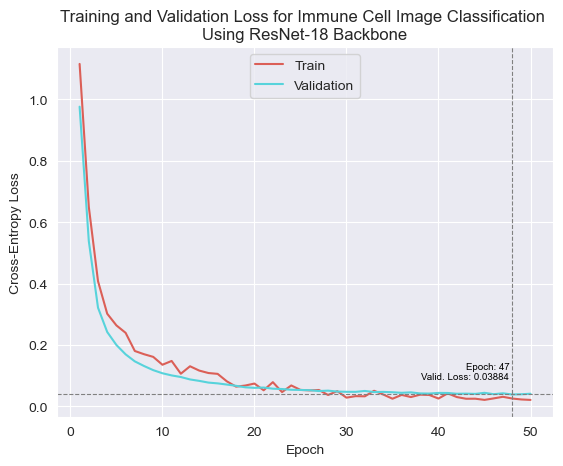

In [66]:
sns.set_style("darkgrid")
sns.lineplot(data=df[['Train', 'Validation']], palette='hls', dashes=False)
plt.ylabel('Cross-Entropy Loss')
plt.title('Training and Validation Loss for Immune Cell Image Classification \nUsing ResNet-18 Backbone')

plt.axvline(x=np.argmin(df.Validation)+1, color='gray', linestyle='--', linewidth='0.8')
plt.axhline(y=np.min(df.Validation), color='gray', linestyle='--', linewidth='0.8')
plt.text(x=np.argmin(df.Validation)+0.7, y=np.min(df.Validation)+0.05, s='Epoch: 47\nValid. Loss: 0.03884', color='black', fontsize=7, ha='right')

filename_train_and_valid="Train and Validation Loss for Immune Cell Image Classification Using Transfer Learning on Resnet-18".replace(" ", "_")
plt.savefig(fname=filename_train_and_valid, dpi=1000)

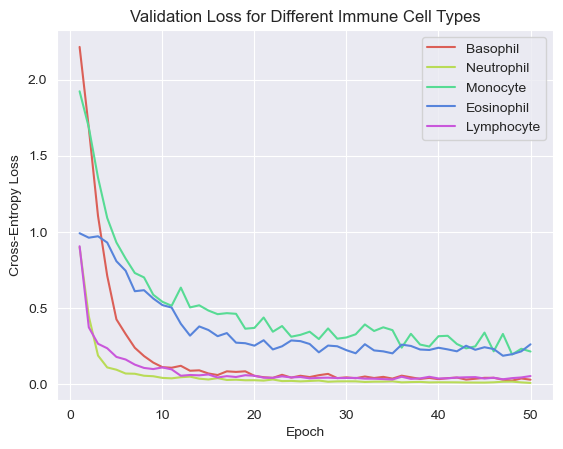

In [65]:
sns.set_style("darkgrid")
sns.lineplot(data=df[['Basophil', 'Neutrophil', 'Monocyte', 'Eosinophil', 'Lymphocyte']], palette='hls', dashes=False)
plt.ylabel('Cross-Entropy Loss')
plt.title('Validation Loss for Different Immune Cell Types')
filename_diff_immune_cell="Validation Loss for Each Immune Cell Type".replace(" ", "_")
plt.savefig(fname=filename_diff_immune_cell, dpi=1000)

In [11]:
torch.argmax(torch.tensor([1, 2, 3]))

tensor(2)

In [38]:
# checking out test dataset
test_dataloader.dataset.immune_cell_counts()

{'Basophil': 27,
 'Neutrophil': 1091,
 'Monocyte': 82,
 'Eosinophil': 111,
 'Lymphocyte': 353}

In [61]:
def classification_accuracy(dataloader, model):
    # set model to evaluation mode
    model.eval()

    total_correct = 0
    total_samples = len(dataloader.dataset)
    
    for batch in tqdm(iter(dataloader)):
        # Every data instance is an input + label pair
        batch_inputs, batch_labels = batch

        # Make predictions for this batch
        batch_outputs = model(batch_inputs).detach()
        
        # Obtaining model consensus
        batch_consensus = torch.argmax(batch_outputs, dim=1)
        total_correct += sum(batch_consensus == batch_labels).item() # get num targets that match consensus

    p_correct = total_correct / total_samples
    
    return p_correct

In [42]:
torch.argmax(torch.tensor([[1, 2, 5], [7, 3, 1]]), dim=1)

tensor([2, 0])

In [50]:
# best validation loss from epoch 47
model=torch.load('models/resnet18_epoch_47_time_04_06_2024_19_42_45') 

In [67]:
# accuracy on test set
classification_accuracy(test_dataloader, model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  7.16it/s]


0.9909855769230769